# How to optimize controls robust to strong noise sources
**Design controls that are robust against strong time-dependent noise sources with stochastic optimization**

In this notebook we demonstrate how to apply stochastic optimization to design robust pulses using our highly-flexible optimization engine. 

The stochastic optimizer is well suited to treat strong and non-static noises, allowing us to go beyond the weak noise regime required for using [filter functions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-and-use-filter-functions-for-arbitrary-controls) in robust optimization as illustrated in [this tutorial](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs).
For stronger noise fields, typically neither the first-order Magnus approximation of the toggling frame Hamiltonian nor the second-order approximation of the time evolution operator hold.

## Summary workflow

### 1. Define the system, variables to be optimized and cost function in the computational graph

The flexible Boulder Opal optimization engine expresses all optimization problems as data flow graphs, which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize).

You can define physical constraints, decide on which variables to optimize and provide a value range, include noise terms, and specify the cost function, which can be based on the target operator and the infidelity.

### 2. Run graph-based optimization

With the graph object created, an optimization can be run by providing the name of the graph node representing the cost function to be minimized, the names of the desired output nodes and the graph itself to the `boulderopal.run_stochastic_optimization` function.

Optionally, you can also set the number of iterations to perform, after which the results with the lowest cost are returned (defaults to 1000), a target cost which early-stops the optimization when/if reached (else the optimizer runs until all iterations are completed), and an optimization algorithm (with Adam as the default). 

The function returns the results of the optimization, which include the lowest cost achieved across all iterations, as well as the specified nodes evaluated at the optimized variables.

You can then use the [qctrlvisualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer) package to plot the optimized pulses, which are available in the result object.

## Example: Robust control of a qubit under strong noise

In this example we show how to find robust controls with the stochastic optimizer.
The single-qubit system is represented by the Hamiltonian
$$ H(t) = (1 + \beta(t))(\gamma_x(t) \sigma_x + \gamma_y(t) \sigma_y) , $$
where $\gamma_x(t)$ and $\gamma_y(t)$ are the real time pulses and $\beta(t)$ is a stochastic noise process.

To perform a stochastic optimization, we assume that the stochastic process can be decomposed into 10 Fourier components
$$ \beta(t) = \sum_{i=1}^{10} a_i \cos(\omega_i t + \phi_i) ,$$
where $a_i$ are random amplitudes sampled from a normal distribution,
$\omega_i$ are random frequencies sampled from a uniform distribution,
and $\phi_i$ are random phases sampled from a uniform distribution.
At each iteration step a new set of samples is taken.

This example uses the nodes `graph.random.uniform` and `graph.random.normal` to generate the stochastic process.
These nodes provide random values sampled from uniform and normal probability distributions, respectively.
Other ways of generating a stochastic process include using the `graph.random.choices` node to shuffle your own set of numerical values (which you can sample from any distribution you want) or `graph.random.colored_noise_stf_signal` to create a stochastic signal from a power spectral density.

The cost is calculated by averaging the infidelities corresponding to a batch of samples of the stochastic process.
Averaging over a batch can lead to more reliable cost function estimates and gradients, which in turn can result in better overall optimization performance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define physical constraints.
duration = 2e-6  # s
gamma_max = 2 * np.pi * 0.5e6  # rad/s
segment_count = 20
batch_size = 200

graph = bo.Graph()

# Define optimizable controls.
gamma_x = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=-gamma_max,
    maximum=gamma_max,
    duration=duration,
    name="gamma_x",
)
gamma_y = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=-gamma_max,
    maximum=gamma_max,
    duration=duration,
    name="gamma_y",
)

# Create noise signals, aᵢ cos(ωᵢt + ϕᵢ).
noise_signals = []
sample_times = (0.5 + np.arange(segment_count)) * duration / segment_count
for _ in range(10):
    a = graph.random.normal(shape=(batch_size, 1), mean=0.0, standard_deviation=0.05)
    omega = graph.random.uniform(
        shape=(batch_size, 1), lower_bound=np.pi, upper_bound=2 * np.pi
    )
    phi = graph.random.uniform(
        shape=(batch_size, 1), lower_bound=0.0, upper_bound=2 * np.pi
    )
    noise_signals.append(
        graph.pwc_signal(
            values=a * graph.cos(omega * sample_times[None] + phi), duration=duration
        )
    )

# Define Hamiltonian.
total_noise = graph.pwc_sum(noise_signals)
hamiltonian = (1 + total_noise) * (
    gamma_x * graph.pauli_matrix("X") + gamma_y * graph.pauli_matrix("Y")
)

# Create infidelity.
infidelities = graph.infidelity_pwc(
    hamiltonian, target=graph.target(graph.pauli_matrix("X")), name="infidelities"
)

# Define cost (average infidelity).
cost = graph.sum(infidelities) / batch_size
cost.name = "cost"

In [3]:
# Run the optimization.
optimization_result = bo.run_stochastic_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["gamma_x", "gamma_y", "infidelities"],
    iteration_count=10000,
    target_cost=1e-6,
)

print(f"\nOptimized cost:\t {optimization_result['cost']:.3e}\n")

Your task (action_id="1828670") has started.
Your task (action_id="1828670") has completed.

Optimized cost:	 3.977e-05



Batch mean: 1.10e-04, standard deviation: 6.24e-04


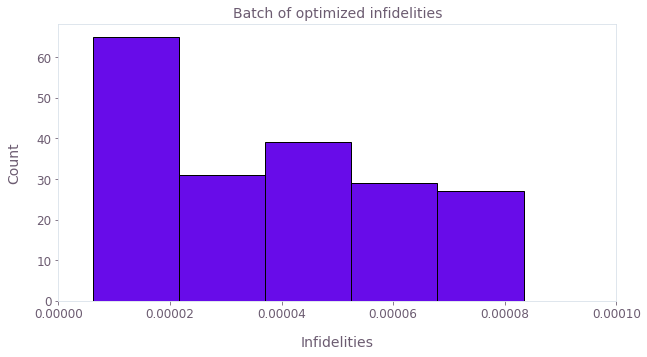

In [4]:
# Plot histogram of infidelities evaluated at the optimized variables.
print(
    f'Batch mean: {optimization_result["output"]["infidelities"]["value"].mean():.2e}, '
    f'standard deviation: {optimization_result["output"]["infidelities"]["value"].std():.2e}'
)

plt.title("Batch of optimized infidelities")
plt.xlabel("Infidelities")
plt.ylabel("Count")
plt.hist(
    optimization_result["output"]["infidelities"]["value"], bins="auto", ec="black"
)
plt.xlim([0.0, 1e-4])
plt.show()

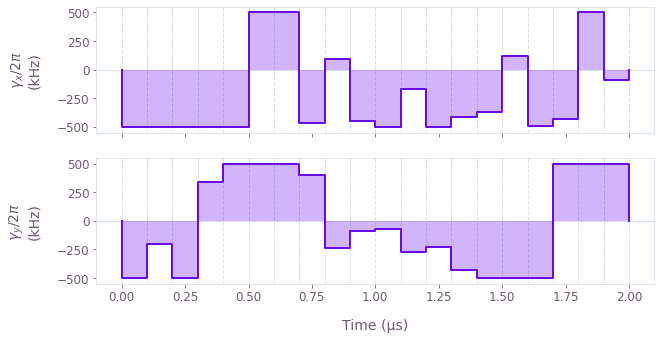

In [5]:
# Plot the optimized controls.
qv.plot_controls(
    {
        r"$\gamma_x$": optimization_result["output"]["gamma_x"],
        r"$\gamma_y$": optimization_result["output"]["gamma_y"],
    }
)